In [ ]:
import pandas as pd
import numpy as np

#seaborn이나 matplotlib 사용하기
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

import time

#sklearn 라이브러리를 사용하기
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import class_weight

%matplotlib inline
import matplotlib.gridspec as GridSpec

#pywt와  scipy라이브러리 사용하기
import pywt
from scipy import fftpack
from scipy import signal
from scipy import optimize
import itertools

In [ ]:
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 5.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=90370cb134f86bd09a6f63cc828a567aea724671edfc882769fd63516dac8154
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from lifelines.utils import k_fold_cross_validation, median_survival_times
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter, NelsonAalenFitter,\
                      CoxPHFitter, WeibullAFTFitter, WeibullFitter, ExponentialFitter,\
                      LogNormalFitter, LogLogisticFitter
from lifelines.statistics import proportional_hazard_test
from lifelines.plotting import plot_lifetimes

In [ ]:
dir_path = '/Users/jinchan/edjjincode/NiseLabProject/Data/'
# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1, 22)]
col_names = index_names + setting_names + sensor_names
# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['time_cycles'])
# inspect first few rows
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [ ]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
print(train.shape)
train[index_names+['RUL']].head()

(20631, 27)


,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [ ]:
# clip RUL max as 125 means values in column greater than 125 becomes 125
train['RUL'].clip(upper=125, inplace=True)

# drop non-informative features, derived from EDA
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = setting_names + drop_sensors
train.drop(labels=drop_labels, axis=1, inplace=True)

remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
                     's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
train.shape

(20631, 17)

In [ ]:
drop_labels

['setting_1',
 'setting_2',
 'setting_3',
 's_1',
 's_5',
 's_6',
 's_10',
 's_16',
 's_18',
 's_19']

In [ ]:
train

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [ ]:
# clip RUL max as 125 means values in column greater than 125 becomes 125
train['RUL'].clip(upper=125, inplace=True)

# drop non-informative features, derived from EDA
drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = setting_names + drop_sensors
train.drop(labels=drop_labels, axis=1, inplace=True)

remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11',
                     's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
train.shape

KeyError: ignored

In [ ]:
train['breakdown'] = 0
idx_last_record = train.reset_index().groupby(by='unit_nr')['index'].last()  # engines breakdown at the last cycle
train.loc[idx_last_record, 'breakdown'] = 1
# this start column is a lifelines specialty
train['start'] = train['time_cycles'] - 1
train.tail() # check results

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198
20630,100,200,643.85,1600.38,1432.14,550.79,2388.26,9061.48,48.20,519.30,2388.26,8137.33,8.5036,396,38.37,23.0522,0,1,199


In [ ]:
idx_last_record = train.reset_index().groupby(by='unit_nr')['index'].last()  # engines breakdown at the last cycle
train.loc[idx_last_record, 'breakdown'] = 1

In [ ]:
train

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198


In [ ]:
# cut off is the censoring cycle time line
cut_off = 200
train_censored = train[train['time_cycles'] <= cut_off].copy()
print(train_censored.shape)
train_censored[train_censored["unit_nr"] == 50].tail()

(18627, 19)


,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
9904,50,194,643.77,1604.93,1423.51,551.41,2388.18,9128.75,48.16,519.85,2388.19,8194.20,8.5043,396,38.42,23.0543,4,0,193
9905,50,195,643.33,1605.31,1434.87,551.25,2388.17,9134.70,48.14,519.33,2388.21,8200.90,8.5352,395,38.45,23.0191,3,0,194
9906,50,196,643.32,1602.26,1430.01,551.40,2388.19,9129.59,48.24,519.88,2388.17,8194.10,8.5034,395,38.45,23.0379,2,0,195
9907,50,197,643.73,1599.94,1432.87,551.18,2388.19,9132.97,48.22,519.48,2388.20,8194.64,8.5241,397,38.52,23.0832,1,0,196
9908,50,198,643.83,1608.20,1433.88,552.06,2388.20,9128.91,48.01,520.00,2388.25,8200.20,8.5002,396,38.43,23.1086,0,1,197


In [ ]:
train_censored

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,RUL,breakdown,start
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,125,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,125,0,1
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,125,0,2
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,125,0,3
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,125,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1,0,198


In [ ]:
df = train_censored[remaining_sensors]

In [ ]:
remaining_sensors

['s_2',
 's_3',
 's_4',
 's_7',
 's_8',
 's_9',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_17',
 's_20',
 's_21']

In [ ]:
def lowpassfilter(signal, thresh = 0.63, wavelet="db4"):
    thresh = thresh*np.nanmax(signal)
    coeff = pywt.wavedec(signal, wavelet, mode="per" )
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, wavelet, mode="per" )
    return reconstructed_signal

In [ ]:
dwt_list = []
for i in range(len(remaining_sensors)):
    dwt = lowpassfilter(df.iloc[:, i], 0.4)
    dwt_list.append(dwt)

In [ ]:
df_dwt = pd.DataFrame(dwt_list)

In [ ]:
df_dwt = df_dwt.T

In [ ]:
df_dwt

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,642.515119,1588.718338,1405.631050,553.696819,2388.070617,9064.199157,47.438527,521.699890,2388.070538,8143.855940,8.428916,392.718746,38.877025,23.325347
1,642.515188,1588.719190,1405.632251,553.696747,2388.070618,9064.204615,47.438552,521.699885,2388.070540,8143.860643,8.428919,392.718878,38.877000,23.325332
2,642.515268,1588.720171,1405.633637,553.696664,2388.070619,9064.210857,47.438582,521.699877,2388.070543,8143.866017,8.428923,392.719031,38.876972,23.325316
3,642.515330,1588.720941,1405.634726,553.696599,2388.070621,9064.215735,47.438605,521.699871,2388.070546,8143.870214,8.428926,392.719152,38.876949,23.325302
4,642.515373,1588.721467,1405.635473,553.696553,2388.070622,9064.218994,47.438621,521.699865,2388.070547,8143.873013,8.428928,392.719236,38.876934,23.325293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18623,642.514875,1588.715327,1405.626787,553.697077,2388.070611,9064.180192,47.438436,521.699917,2388.070528,8143.839635,8.428905,392.718275,38.877114,23.325399
18624,642.514931,1588.716011,1405.627760,553.697017,2388.070613,9064.184416,47.438457,521.699909,2388.070531,8143.843257,8.428908,392.718382,38.877093,23.325387
18625,642.514974,1588.716549,1405.628523,553.696971,2388.070614,9064.187815,47.438473,521.699905,2388.070532,8143.846180,8.428910,392.718467,38.877078,23.325378
18626,642.515005,1588.716931,1405.629068,553.696937,2388.070615,9064.190114,47.438485,521.699899,2388.070534,8143.848147,8.428911,392.718527,38.877066,23.325371


In [ ]:
df_dwt.columns = remaining_sensors

In [ ]:
df_dwt

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,642.515119,1588.718338,1405.631050,553.696819,2388.070617,9064.199157,47.438527,521.699890,2388.070538,8143.855940,8.428916,392.718746,38.877025,23.325347
1,642.515188,1588.719190,1405.632251,553.696747,2388.070618,9064.204615,47.438552,521.699885,2388.070540,8143.860643,8.428919,392.718878,38.877000,23.325332
2,642.515268,1588.720171,1405.633637,553.696664,2388.070619,9064.210857,47.438582,521.699877,2388.070543,8143.866017,8.428923,392.719031,38.876972,23.325316
3,642.515330,1588.720941,1405.634726,553.696599,2388.070621,9064.215735,47.438605,521.699871,2388.070546,8143.870214,8.428926,392.719152,38.876949,23.325302
4,642.515373,1588.721467,1405.635473,553.696553,2388.070622,9064.218994,47.438621,521.699865,2388.070547,8143.873013,8.428928,392.719236,38.876934,23.325293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18623,642.514875,1588.715327,1405.626787,553.697077,2388.070611,9064.180192,47.438436,521.699917,2388.070528,8143.839635,8.428905,392.718275,38.877114,23.325399
18624,642.514931,1588.716011,1405.627760,553.697017,2388.070613,9064.184416,47.438457,521.699909,2388.070531,8143.843257,8.428908,392.718382,38.877093,23.325387
18625,642.514974,1588.716549,1405.628523,553.696971,2388.070614,9064.187815,47.438473,521.699905,2388.070532,8143.846180,8.428910,392.718467,38.877078,23.325378
18626,642.515005,1588.716931,1405.629068,553.696937,2388.070615,9064.190114,47.438485,521.699899,2388.070534,8143.848147,8.428911,392.718527,38.877066,23.325371


In [ ]:
df_1 = train_censored["unit_nr"]

In [ ]:
df = pd.concat([df_1, df_dwt], axis = 1)

In [ ]:
df_2 = train_censored[["time_cycles", "RUL"]]

In [ ]:
df_new = pd.concat([df, df_2], axis = 1)

In [ ]:
df_new

,unit_nr,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,time_cycles,RUL
0,1.0,642.515119,1588.718338,1405.631050,553.696819,2388.070617,9064.199157,47.438527,521.699890,2388.070538,8143.855940,8.428916,392.718746,38.877025,23.325347,1.0,125.0
1,1.0,642.515188,1588.719190,1405.632251,553.696747,2388.070618,9064.204615,47.438552,521.699885,2388.070540,8143.860643,8.428919,392.718878,38.877000,23.325332,2.0,125.0
2,1.0,642.515268,1588.720171,1405.633637,553.696664,2388.070619,9064.210857,47.438582,521.699877,2388.070543,8143.866017,8.428923,392.719031,38.876972,23.325316,3.0,125.0
3,1.0,642.515330,1588.720941,1405.634726,553.696599,2388.070621,9064.215735,47.438605,521.699871,2388.070546,8143.870214,8.428926,392.719152,38.876949,23.325302,4.0,125.0
4,1.0,642.515373,1588.721467,1405.635473,553.696553,2388.070622,9064.218994,47.438621,521.699865,2388.070547,8143.873013,8.428928,392.719236,38.876934,23.325293,5.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18221,NaN,642.492785,1588.455913,1405.229495,553.726459,2388.069153,9063.058787,47.428807,521.711204,2388.068790,8142.922854,8.427717,392.673249,38.885093,23.330036,NaN,NaN
18222,NaN,642.492802,1588.456157,1405.229739,553.726465,2388.069150,9063.062137,47.428808,521.711235,2388.068788,8142.925927,8.427717,392.673275,38.885087,23.330033,NaN,NaN
18223,NaN,642.492817,1588.456382,1405.229948,553.726474,2388.069147,9063.065503,47.428808,521.711268,2388.068785,8142.929028,8.427717,392.673297,38.885082,23.330029,NaN,NaN
18224,NaN,642.492831,1588.456585,1405.230118,553.726488,2388.069143,9063.068889,47.428807,521.711304,2388.068782,8142.932162,8.427717,392.673314,38.885077,23.330026,NaN,NaN


In [ ]:
df_new.dropna(inplace = True)

In [ ]:
df_new

,unit_nr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,time_cycles,RUL
0,1.0,642.515119,1588.718338,1405.631050,553.696819,2388.070617,9064.199157,47.438527,521.699890,2388.070538,8143.855940,8.428916,392.718746,38.877025,23.325347,1.0,125.0
1,1.0,642.515188,1588.719190,1405.632251,553.696747,2388.070618,9064.204615,47.438552,521.699885,2388.070540,8143.860643,8.428919,392.718878,38.877000,23.325332,2.0,125.0
2,1.0,642.515268,1588.720171,1405.633637,553.696664,2388.070619,9064.210857,47.438582,521.699877,2388.070543,8143.866017,8.428923,392.719031,38.876972,23.325316,3.0,125.0
3,1.0,642.515330,1588.720941,1405.634726,553.696599,2388.070621,9064.215735,47.438605,521.699871,2388.070546,8143.870214,8.428926,392.719152,38.876949,23.325302,4.0,125.0
4,1.0,642.515373,1588.721467,1405.635473,553.696553,2388.070622,9064.218994,47.438621,521.699865,2388.070547,8143.873013,8.428928,392.719236,38.876934,23.325293,5.0,125.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18623,92.0,642.514875,1588.715327,1405.626787,553.697077,2388.070611,9064.180192,47.438436,521.699917,2388.070528,8143.839635,8.428905,392.718275,38.877114,23.325399,109.0,125.0
18624,92.0,642.514931,1588.716011,1405.627760,553.697017,2388.070613,9064.184416,47.438457,521.699909,2388.070531,8143.843257,8.428908,392.718382,38.877093,23.325387,110.0,125.0
18625,92.0,642.514974,1588.716549,1405.628523,553.696971,2388.070614,9064.187815,47.438473,521.699905,2388.070532,8143.846180,8.428910,392.718467,38.877078,23.325378,111.0,125.0
18626,92.0,642.515005,1588.716931,1405.629068,553.696937,2388.070615,9064.190114,47.438485,521.699899,2388.070534,8143.848147,8.428911,392.718527,38.877066,23.325371,112.0,125.0


In [ ]:
df_3 = train_censored[['start', 'breakdown']]

In [ ]:
df_new = pd.concat([df_new, df_3], axis = 1)

In [ ]:
df_new

,unit_nr,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,time_cycles,RUL,start,breakdown
0,1.0,642.515119,1588.718338,1405.631050,553.696819,2388.070617,9064.199157,47.438527,521.699890,2388.070538,8143.855940,8.428916,392.718746,38.877025,23.325347,1.0,125.0,0.0,0.0
1,1.0,642.515188,1588.719190,1405.632251,553.696747,2388.070618,9064.204615,47.438552,521.699885,2388.070540,8143.860643,8.428919,392.718878,38.877000,23.325332,2.0,125.0,1.0,0.0
2,1.0,642.515268,1588.720171,1405.633637,553.696664,2388.070619,9064.210857,47.438582,521.699877,2388.070543,8143.866017,8.428923,392.719031,38.876972,23.325316,3.0,125.0,2.0,0.0
3,1.0,642.515330,1588.720941,1405.634726,553.696599,2388.070621,9064.215735,47.438605,521.699871,2388.070546,8143.870214,8.428926,392.719152,38.876949,23.325302,4.0,125.0,3.0,0.0
4,1.0,642.515373,1588.721467,1405.635473,553.696553,2388.070622,9064.218994,47.438621,521.699865,2388.070547,8143.873013,8.428928,392.719236,38.876934,23.325293,5.0,125.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18221,NaN,642.492785,1588.455913,1405.229495,553.726459,2388.069153,9063.058787,47.428807,521.711204,2388.068790,8142.922854,8.427717,392.673249,38.885093,23.330036,NaN,NaN,NaN,NaN
18222,NaN,642.492802,1588.456157,1405.229739,553.726465,2388.069150,9063.062137,47.428808,521.711235,2388.068788,8142.925927,8.427717,392.673275,38.885087,23.330033,NaN,NaN,NaN,NaN
18223,NaN,642.492817,1588.456382,1405.229948,553.726474,2388.069147,9063.065503,47.428808,521.711268,2388.068785,8142.929028,8.427717,392.673297,38.885082,23.330029,NaN,NaN,NaN,NaN
18224,NaN,642.492831,1588.456585,1405.230118,553.726488,2388.069143,9063.068889,47.428807,521.711304,2388.068782,8142.932162,8.427717,392.673314,38.885077,23.330026,NaN,NaN,NaN,NaN


In [ ]:
df_new.dropna(inplace = True)

In [ ]:
train_cols = index_names + remaining_sensors + ['start', 'breakdown']
predict_cols = ['time_cycles'] + remaining_sensors + ['start', 'breakdown']  # breakdown value will be 0
ctv = CoxTimeVaryingFitter(penalizer=0.1)
ctv.fit(df_new[train_cols], id_col="unit_nr", event_col='breakdown',
        start_col='start', stop_col='time_cycles', show_progress=True)

Iteration 1: norm_delta = 1.56e-02, step_size = 0.9500, log_lik = -208.62929, newton_decrement = 3.10e-01, seconds_since_start = 0.0
Iteration 2: norm_delta = 8.08e-04, step_size = 0.9500, log_lik = -208.31983, newton_decrement = 8.25e-04, seconds_since_start = 0.0
Iteration 3: norm_delta = 4.05e-05, step_size = 0.9500, log_lik = -208.31900, newton_decrement = 2.07e-06, seconds_since_start = 0.1
Iteration 4: norm_delta = 2.13e-06, step_size = 1.0000, log_lik = -208.31900, newton_decrement = 5.18e-09, seconds_since_start = 0.1
Convergence completed after 4 iterations.


/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['s_15'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


<lifelines.CoxTimeVaryingFitter: fitted with 17044 periods, 92 subjects, 50 events>

<lifelines.CoxTimeVaryingFitter: fitted with 17044 periods, 92 subjects, 50 events>
         event col = 'breakdown'
         penalizer = 0.1
number of subjects = 92
 number of periods = 17044
  number of events = 50
partial log-likelihood = -208.32
  time fit was run = 2023-09-30 10:12:48 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
s_2         0.07       1.07       0.33            -0.57             0.71                 0.56                 2.03
s_3         0.01       1.01       0.03            -0.05             0.06                 0.95                 1.07
s_4         0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
s_7        -0.03       0.97       0.16            -0.34             0.28                 0.71                 1.32
s_8         0.26       1.29       1.63            -2.94             3.45                 0.05                31.60
s_9        -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
s_11        0.10       1.11       0.52            -0.92             1.13                 0.40                 3.08
s_12       -0.04       0.96       0.18            -0.39             0.32                 0.67                 1.37
s_13        0.28       1.33       1.60            -2.86             3.42                 0.06                30.64
s_14       -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
s_15        0.88       2.41       4.19            -7.33             9.09                 0.00              8835.55
s_17        0.02       1.02       0.11            -0.20             0.25                 0.82                 1.28
s_20       -0.18       0.84       0.90            -1.95             1.59                 0.14                 4.90
s_21       -0.33       0.72       1.57            -3.42             2.75                 0.03                15.69

            cmp to     z    p   -log2(p)
covariate                               
s_2           0.00  0.21 0.84       0.26
s_3           0.00  0.19 0.85       0.24
s_4           0.00  0.21 0.84       0.26
s_7           0.00 -0.19 0.85       0.24
s_8           0.00  0.16 0.87       0.19
s_9           0.00 -0.01 0.99       0.01
s_11          0.00  0.20 0.84       0.25
s_12          0.00 -0.21 0.83       0.26
s_13          0.00  0.18 0.86       0.22
s_14          0.00 -0.05 0.96       0.05
s_15          0.00  0.21 0.83       0.26
s_17          0.00  0.21 0.84       0.26
s_20          0.00 -0.20 0.84       0.25
s_21          0.00 -0.21 0.83       0.26
---
Partial AIC = 444.64
log-likelihood ratio test = 0.62 on 14 df
-log2(p) of ll-ratio test = 0.00

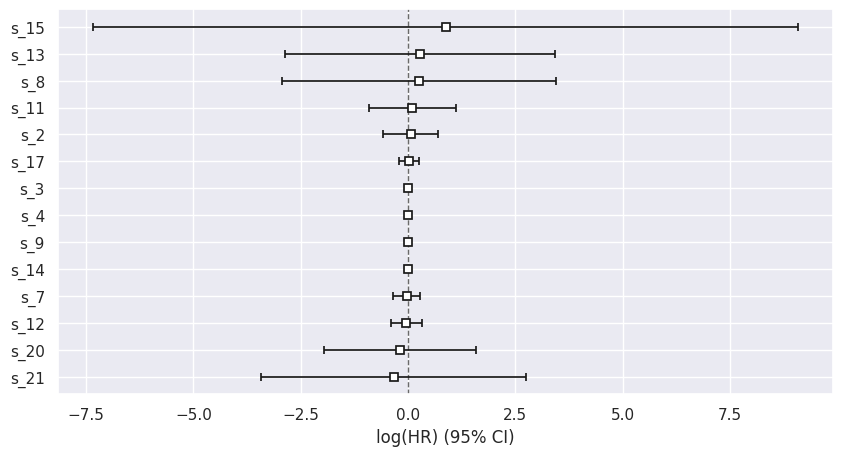

In [ ]:
ctv.print_summary()
plt.figure(figsize=(10,5))
ctv.plot()
plt.show()
plt.close()

In [ ]:
# get the last unit time series data frame
df = df_new.groupby("unit_nr").last()
df = df[df['breakdown'] == 0]  # get engines from dataset which are still functioning so we can predict their RUL
df_to_predict = df.copy().reset_index()
# predictions = pd.DataFrame(ctv.predict_log_partial_hazard(df_to_predict[predict_cols]), index=df_to_predict.index)
predictions = ctv.predict_log_partial_hazard(df_to_predict[predict_cols]).to_frame()
predictions.rename(columns={0: "predictions"}, inplace=True)
df_last = train.groupby('unit_nr').last()
predictions['RUL'] = df_to_predict['RUL']
predictions.head(10)

,predictions,RUL
0,-0.075447,87.0
1,-0.059861,69.0
2,-0.039093,59.0
3,-0.014442,1.0
4,-0.000864,22.0
5,0.009701,40.0
6,0.030605,7.0
7,0.034867,9.0
8,0.039353,76.0
9,0.045496,34.0


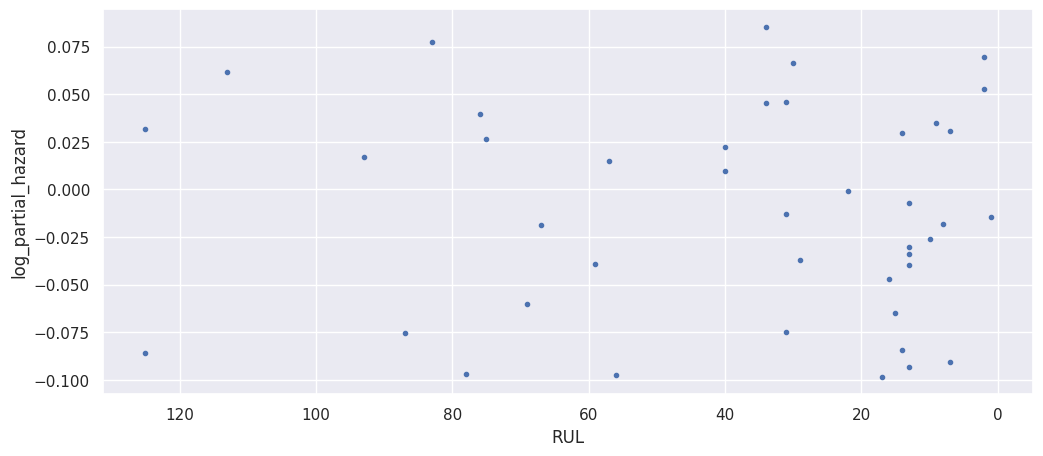

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(predictions['RUL'], predictions['predictions'], '.b')
xlim = plt.gca().get_xlim()
plt.xlim(xlim[1], xlim[0])
plt.xlabel('RUL')
plt.ylabel('log_partial_hazard')
plt.show()

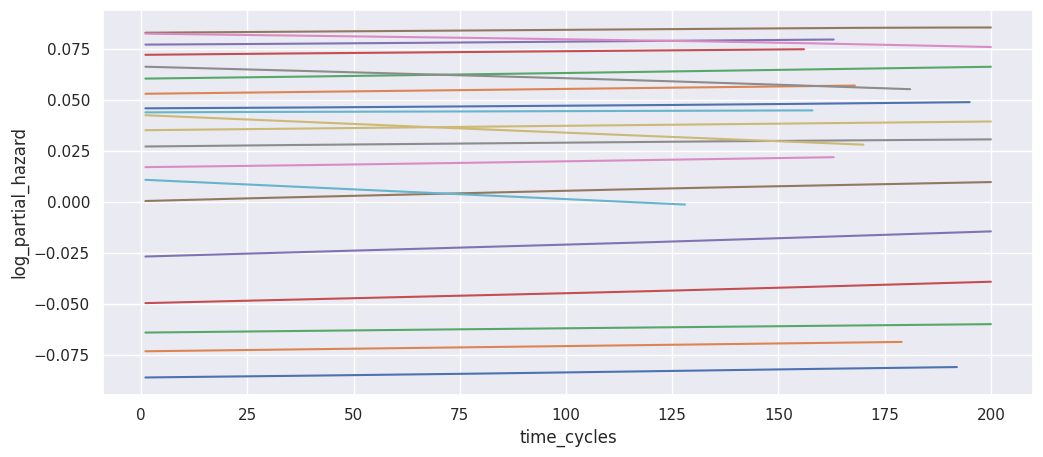

In [ ]:
# now lets look at some hazard trajectories
X = df_new.loc[df_new['unit_nr'].isin(df_to_predict.index)]
X_unique = len(X['unit_nr'].unique())
plt.figure(figsize=(12,5))
for i in range(1, X_unique, 2):
    X_sub = X.loc[X['unit_nr'] == i]
    predictions = ctv.predict_partial_hazard(X_sub).values
    plt.plot(X_sub['time_cycles'].values, np.log(predictions))

plt.xlabel('time_cycles')
plt.ylabel('log_partial_hazard')
plt.show()

In [ ]:
df_hazard = df_new.copy().reset_index()
df_hazard['hazard'] = ctv.predict_log_partial_hazard(df_hazard)
df_hazard.head()

,index,unit_nr,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,...,s_14,s_15,s_17,s_20,s_21,time_cycles,RUL,start,breakdown,hazard
0,0,1.0,642.515119,1588.718338,1405.631050,553.696819,2388.070617,9064.199157,47.438527,521.699890,...,8143.855940,8.428916,392.718746,38.877025,23.325347,1.0,125.0,0.0,0.0,-0.085982
1,1,1.0,642.515188,1588.719190,1405.632251,553.696747,2388.070618,9064.204615,47.438552,521.699885,...,8143.860643,8.428919,392.718878,38.877000,23.325332,2.0,125.0,1.0,0.0,-0.085950
2,2,1.0,642.515268,1588.720171,1405.633637,553.696664,2388.070619,9064.210857,47.438582,521.699877,...,8143.866017,8.428923,392.719031,38.876972,23.325316,3.0,125.0,2.0,0.0,-0.085912
3,3,1.0,642.515330,1588.720941,1405.634726,553.696599,2388.070621,9064.215735,47.438605,521.699871,...,8143.870214,8.428926,392.719152,38.876949,23.325302,4.0,125.0,3.0,0.0,-0.085882
4,4,1.0,642.515373,1588.721467,1405.635473,553.696553,2388.070622,9064.218994,47.438621,521.699865,...,8143.873013,8.428928,392.719236,38.876934,23.325293,5.0,125.0,4.0,0.0,-0.085861


In [ ]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

def exponential_model(z, a, b):
    return a * np.exp(-b * z)

popt, pcov = curve_fit(exponential_model, df_hazard['hazard'], df_hazard['RUL'])
print(popt)

[91.36473145  0.32150002]


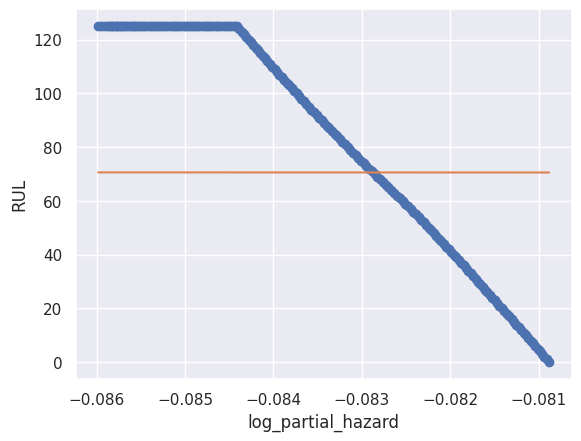

In [ ]:
#Idea of fit: The line that was actually fitted is less accurate as it takes data points of all engines into account.
# check specific unit_nr
y_hat = exponential_model(df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], 70, 0.1)
plt.plot(df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], df_hazard.loc[df_hazard['unit_nr']==1, 'RUL'], 'o',
         df_hazard.loc[df_hazard['unit_nr']==1, 'hazard'], y_hat)
plt.xlabel("log_partial_hazard")
plt.ylabel("RUL")
plt.show()
plt.close()

In [ ]:
test

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [ ]:
# prep test set
test = test.drop(labels=drop_labels, axis=1)
test['breakdown'] = 0
test['start'] = test['time_cycles'] - 1

In [ ]:
test

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,breakdown,start
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,0,0
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,0,1
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,0,2
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,0,3
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,0,193
13092,100,195,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,0,194
13093,100,196,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,0,195
13094,100,197,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,0,196


In [ ]:
df_t = test[remaining_sensors]

In [ ]:
df_t

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735
1,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916
2,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166
3,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737
4,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974
13092,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771
13093,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051
13094,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699


In [ ]:
dwt_list = []
for i in range(len(remaining_sensors)):
    dwt = lowpassfilter(df_t.iloc[:, i], 0.4)
    dwt_list.append(dwt)

In [ ]:
df_test_dwt = pd.DataFrame(dwt_list)

In [ ]:
df_test_dwt

,0,1,2,3,4,5,6,7,8,9,...,13086,13087,13088,13089,13090,13091,13092,13093,13094,13095
0,642.501211,642.501718,642.502263,642.502724,642.503098,642.503434,642.503701,642.503992,642.504314,642.504592,...,642.497573,642.497957,642.498256,642.498507,642.498694,642.498977,642.499375,642.499797,642.500289,642.500763
1,1588.502389,1588.508358,1588.514790,1588.520213,1588.524620,1588.528579,1588.531719,1588.535148,1588.538928,1588.542200,...,1588.459500,1588.464026,1588.467540,1588.470500,1588.472709,1588.476054,1588.480742,1588.485718,1588.491511,1588.497098
2,1405.562653,1405.573642,1405.585484,1405.595468,1405.603584,1405.610873,1405.616656,1405.622972,1405.629934,1405.635964,...,1405.483694,1405.492028,1405.498498,1405.503947,1405.508012,1405.514170,1405.522800,1405.531960,1405.542626,1405.552912
3,553.693330,553.692126,553.690828,553.689733,553.688843,553.688043,553.687407,553.686713,553.685948,553.685284,...,553.701983,553.701069,553.700360,553.699763,553.699318,553.698644,553.697698,553.696694,553.695525,553.694398
4,2388.079542,2388.079683,2388.079836,2388.079965,2388.080071,2388.080165,2388.080241,2388.080323,2388.080414,2388.080492,...,2388.078522,2388.078630,2388.078713,2388.078784,2388.078836,2388.078916,2388.079027,2388.079145,2388.079283,2388.079416
5,9058.504921,9058.481384,9058.456023,9058.434522,9058.416886,9058.400947,9058.388122,9058.374121,9058.358703,9058.345180,...,9058.674137,9058.656294,9058.642425,9058.630734,9058.621991,9058.608781,9058.590289,9058.570665,9058.547825,9058.525793
6,47.439291,47.439624,47.439983,47.440285,47.440531,47.440751,47.440926,47.441117,47.441328,47.441510,...,47.436900,47.437153,47.437349,47.437514,47.437637,47.437823,47.438085,47.438362,47.438685,47.438997
7,521.692994,521.691955,521.690837,521.689893,521.689125,521.688434,521.687885,521.687286,521.686625,521.686051,...,521.700452,521.699664,521.699053,521.698538,521.698155,521.697573,521.696758,521.695893,521.694885,521.693914
8,2388.076456,2388.076592,2388.076738,2388.076862,2388.076962,2388.077053,2388.077125,2388.077204,2388.077291,2388.077366,...,2388.075481,2388.075584,2388.075664,2388.075731,2388.075781,2388.075857,2388.075964,2388.076077,2388.076209,2388.076336
9,8138.675383,8138.650371,8138.623421,8138.600588,8138.581880,8138.564986,8138.551415,8138.536600,8138.520283,8138.505994,...,8138.855193,8138.836231,8138.821495,8138.809073,8138.799786,8138.785751,8138.766100,8138.745247,8138.720975,8138.697562


In [ ]:
df_test_dwt = df_test_dwt.T

In [ ]:
df_test_dwt.columns = remaining_sensors

In [ ]:
df_test_dwt

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,642.501211,1588.502389,1405.562653,553.693330,2388.079542,9058.504921,47.439291,521.692994,2388.076456,8138.675383,8.428767,392.601948,38.883405,23.325399
1,642.501718,1588.508358,1405.573642,553.692126,2388.079683,9058.481384,47.439624,521.691955,2388.076592,8138.650371,8.428812,392.603254,38.883215,23.325284
2,642.502263,1588.514790,1405.585484,553.690828,2388.079836,9058.456023,47.439983,521.690837,2388.076738,8138.623421,8.428861,392.604662,38.883011,23.325161
3,642.502724,1588.520213,1405.595468,553.689733,2388.079965,9058.434522,47.440285,521.689893,2388.076862,8138.600588,8.428902,392.605849,38.882839,23.325056
4,642.503098,1588.524620,1405.603584,553.688843,2388.080071,9058.416886,47.440531,521.689125,2388.076962,8138.581880,8.428935,392.606816,38.882699,23.324972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,642.498977,1588.476054,1405.514170,553.698644,2388.078916,9058.608781,47.437823,521.697573,2388.075857,8138.785751,8.428567,392.596185,38.884242,23.325905
13092,642.499375,1588.480742,1405.522800,553.697698,2388.079027,9058.590289,47.438085,521.696758,2388.075964,8138.766100,8.428603,392.597212,38.884093,23.325815
13093,642.499797,1588.485718,1405.531960,553.696694,2388.079145,9058.570665,47.438362,521.695893,2388.076077,8138.745247,8.428640,392.598300,38.883935,23.325720
13094,642.500289,1588.491511,1405.542626,553.695525,2388.079283,9058.547825,47.438685,521.694885,2388.076209,8138.720975,8.428684,392.599569,38.883751,23.325608


In [ ]:
df_1 = test["unit_nr"]

In [ ]:
df_2 = test["time_cycles"]

In [ ]:
df_3 = test[['start', 'breakdown']]

In [ ]:
df_test_new = pd.concat([df_1, df_test_dwt, df_2, df_3], axis = 1)

In [ ]:
df_test_new

,unit_nr,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,time_cycles,start,breakdown
0,1,642.501211,1588.502389,1405.562653,553.693330,2388.079542,9058.504921,47.439291,521.692994,2388.076456,8138.675383,8.428767,392.601948,38.883405,23.325399,1,0,0
1,1,642.501718,1588.508358,1405.573642,553.692126,2388.079683,9058.481384,47.439624,521.691955,2388.076592,8138.650371,8.428812,392.603254,38.883215,23.325284,2,1,0
2,1,642.502263,1588.514790,1405.585484,553.690828,2388.079836,9058.456023,47.439983,521.690837,2388.076738,8138.623421,8.428861,392.604662,38.883011,23.325161,3,2,0
3,1,642.502724,1588.520213,1405.595468,553.689733,2388.079965,9058.434522,47.440285,521.689893,2388.076862,8138.600588,8.428902,392.605849,38.882839,23.325056,4,3,0
4,1,642.503098,1588.524620,1405.603584,553.688843,2388.080071,9058.416886,47.440531,521.689125,2388.076962,8138.581880,8.428935,392.606816,38.882699,23.324972,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,642.498977,1588.476054,1405.514170,553.698644,2388.078916,9058.608781,47.437823,521.697573,2388.075857,8138.785751,8.428567,392.596185,38.884242,23.325905,194,193,0
13092,100,642.499375,1588.480742,1405.522800,553.697698,2388.079027,9058.590289,47.438085,521.696758,2388.075964,8138.766100,8.428603,392.597212,38.884093,23.325815,195,194,0
13093,100,642.499797,1588.485718,1405.531960,553.696694,2388.079145,9058.570665,47.438362,521.695893,2388.076077,8138.745247,8.428640,392.598300,38.883935,23.325720,196,195,0
13094,100,642.500289,1588.491511,1405.542626,553.695525,2388.079283,9058.547825,47.438685,521.694885,2388.076209,8138.720975,8.428684,392.599569,38.883751,23.325608,197,196,0


In [ ]:
test.groupby('unit_nr').last()

,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,breakdown,start
unit_nr,,,,,,,,,,,,,,,,,
1,31,642.58,1581.22,1398.91,554.42,2388.08,9056.40,47.23,521.79,2388.06,8130.11,8.4024,393,38.81,23.3552,0,30
2,49,642.55,1586.59,1410.83,553.52,2388.10,9044.77,47.67,521.74,2388.09,8126.90,8.4505,391,38.81,23.2618,0,48
3,126,642.88,1589.75,1418.89,552.59,2388.16,9049.26,47.88,520.83,2388.14,8131.46,8.4119,395,38.93,23.2740,0,125
4,106,642.78,1594.53,1406.88,552.64,2388.13,9051.30,47.65,521.88,2388.11,8133.64,8.4634,395,38.58,23.2581,0,105
5,98,642.27,1589.94,1419.36,553.29,2388.10,9053.99,47.46,521.00,2388.15,8125.74,8.4362,394,38.75,23.4117,0,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,97,642.30,1590.88,1397.94,553.99,2388.03,9062.41,47.14,522.30,2388.01,8148.24,8.4110,391,38.96,23.4606,0,96
97,134,642.59,1582.96,1410.92,554.05,2388.06,9076.36,47.38,521.58,2388.06,8155.48,8.4500,395,38.61,23.2953,0,133
98,121,642.68,1599.51,1415.47,553.44,2388.13,9062.34,47.66,521.53,2388.09,8146.39,8.4235,394,38.76,23.3608,0,120


In [ ]:
# predict and evaluate
y_hat = exponential_model(df_hazard['hazard'], *popt)
evaluate(df_hazard['RUL'], y_hat, 'train')

y_pred = ctv.predict_log_partial_hazard(df_test_new.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt)
evaluate(df_test, y_hat)

train set RMSE:39.19235704674065, R2:0.0018667656108727337
test set RMSE:45.46728233719949, R2:-0.19712210066736535


In [ ]:
def mse_evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    print('{} set MSE:{}'.format(label, mse))

In [ ]:
mse_evaluate(df_test, y_hat)

test set MSE:706.5489660693307


In [ ]:
df_new [train_cols]

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,start,breakdown
0,1.0,1.0,642.515119,1588.718338,1405.631050,553.696819,2388.070617,9064.199157,47.438527,521.699890,2388.070538,8143.855940,8.428916,392.718746,38.877025,23.325347,0.0,0.0
1,1.0,2.0,642.515188,1588.719190,1405.632251,553.696747,2388.070618,9064.204615,47.438552,521.699885,2388.070540,8143.860643,8.428919,392.718878,38.877000,23.325332,1.0,0.0
2,1.0,3.0,642.515268,1588.720171,1405.633637,553.696664,2388.070619,9064.210857,47.438582,521.699877,2388.070543,8143.866017,8.428923,392.719031,38.876972,23.325316,2.0,0.0
3,1.0,4.0,642.515330,1588.720941,1405.634726,553.696599,2388.070621,9064.215735,47.438605,521.699871,2388.070546,8143.870214,8.428926,392.719152,38.876949,23.325302,3.0,0.0
4,1.0,5.0,642.515373,1588.721467,1405.635473,553.696553,2388.070622,9064.218994,47.438621,521.699865,2388.070547,8143.873013,8.428928,392.719236,38.876934,23.325293,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18623,92.0,109.0,642.514875,1588.715327,1405.626787,553.697077,2388.070611,9064.180192,47.438436,521.699917,2388.070528,8143.839635,8.428905,392.718275,38.877114,23.325399,108.0,0.0
18624,92.0,110.0,642.514931,1588.716011,1405.627760,553.697017,2388.070613,9064.184416,47.438457,521.699909,2388.070531,8143.843257,8.428908,392.718382,38.877093,23.325387,109.0,0.0
18625,92.0,111.0,642.514974,1588.716549,1405.628523,553.696971,2388.070614,9064.187815,47.438473,521.699905,2388.070532,8143.846180,8.428910,392.718467,38.877078,23.325378,110.0,0.0
18626,92.0,112.0,642.515005,1588.716931,1405.629068,553.696937,2388.070615,9064.190114,47.438485,521.699899,2388.070534,8143.848147,8.428911,392.718527,38.877066,23.325371,111.0,0.0


In [ ]:
train[train_cols]

,unit_nr,time_cycles,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,start,breakdown
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,1,0
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,2,0
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,3,0
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,195,0
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,196,0
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,197,0
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,198,0


In [ ]:
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(df_new [train_cols], id_col="unit_nr", event_col='breakdown',
         start_col='start', stop_col='time_cycles', show_progress=True)

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['s_15'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


ConvergenceError: ignored

In [ ]:
ctv2 = CoxTimeVaryingFitter()
ctv2.fit(df_new [train_cols], id_col="unit_nr", event_col='breakdown',
         start_col='start', stop_col='time_cycles', show_progress=True)

train['hazard'] = ctv2.predict_log_partial_hazard(train)
popt2, pcov2 = curve_fit(exponential_model, train['hazard'], train['RUL'])

y_hat = exponential_model(train['hazard'], *popt2)
evaluate(train['RUL'], y_hat, 'train')

y_pred = ctv2.predict_log_partial_hazard(test.groupby('unit_nr').last())
y_hat = exponential_model(y_pred, *popt2)
evaluate(df_test, y_hat)

Iteration 1: norm_delta = 1.00e+00, step_size = 0.9500, log_lik = -363.73938, newton_decrement = 1.69e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.23e+00, step_size = 0.9500, log_lik = -196.95744, newton_decrement = 6.53e+01, seconds_since_start = 0.1
Iteration 3: norm_delta = 7.49e-01, step_size = 0.9500, log_lik = -141.32406, newton_decrement = 2.53e+01, seconds_since_start = 0.1
Iteration 4: norm_delta = 7.27e-01, step_size = 0.9310, log_lik = -129.43964, newton_decrement = 1.68e+01, seconds_since_start = 0.1
Iteration 5: norm_delta = 2.30e-01, step_size = 1.0000, log_lik = -115.92018, newton_decrement = 1.13e+00, seconds_since_start = 0.2
Iteration 6: norm_delta = 4.04e-02, step_size = 1.0000, log_lik = -114.78357, newton_decrement = 1.24e-02, seconds_since_start = 0.2
Iteration 7: norm_delta = 5.62e-04, step_size = 1.0000, log_lik = -114.77107, newton_decrement = 2.21e-06, seconds_since_start = 0.2
Iteration 8: norm_delta = 1.18e-07, step_size = 1.0000, log_lik = -11